Dans ce script, nous allons tester différents modèles de type convolutionnelsur le dataset 

résultat:
* l'utilisation des batchs rend l'inférence globale plus rapide
* un modèle a besoin de beaucoup de temps / parametres pour arriver à un certain niveau d'accuracy

In [1]:
import retinoto_py as fovea
args = fovea.Params()
args

Welcome on macOS-26.1-arm64-arm-64bit-Mach-O	 user laurentperrinet	Running on MPS device (Apple Silicon/MacOS)	 - macos_version = 26.1	 with device mps, pytorch==2.9.1
Random seed 1998 has been set.


Params(image_size=224, do_mask=False, num_epochs=5, n_train_stop=0, seed=1998, batch_size=64, label_smoothing=0.0, model_name='resnet18', do_scratch=False, shuffle=True, num_workers=2, verbose=True)

# testing a ResNet50 model on the validation dataset

In [2]:
VAL_DATA_DIR = args.DATAROOT / 'Imagenet_full' / 'val'

In [3]:
from retinoto_py import get_loader
val_loader, class_to_idx, idx_to_class = get_loader(args, VAL_DATA_DIR)

In [4]:
from retinoto_py import load_model, count_parameters, count_layers
model = load_model(args)
model.eval()
# --- Parameter Counts ---
param_stats = count_parameters(model)
print("🔢 Parameter Count:")
print(f"  Total:     {param_stats['total_parameters']:,}")
print(f"  Trainable: {param_stats['trainable_parameters']:,}")
print("-" * 50)

# --- Layer Counts ---
print("🧱 Layer Count:")
# 1. Total number of nn.Module objects
total_layers = count_layers(model)
print(f"  Total Modules (nn.Module): {total_layers}")

# 2. Counting specific layer types
from torch import nn

conv_layers = count_layers(model, layer_type=nn.Conv2d)
linear_layers = count_layers(model, layer_type=nn.Linear)
print(f"  Convolutional (nn.Conv2d): {conv_layers}")
print(f"  Linear (nn.Linear): {linear_layers}")
print("=" * 50)

🔢 Parameter Count:
  Total:     11,689,512
  Trainable: 11,689,512
--------------------------------------------------
🧱 Layer Count:
  Total Modules (nn.Module): 68
  Convolutional (nn.Conv2d): 20
  Linear (nn.Linear): 1


In [ ]:
import torch
import pandas as pd

from retinoto_py import get_validation_accuracy

json_filename = args.data_cache / '11_model_accuracy.json'

if json_filename.exists():
    results = pd.read_json(json_filename)
else:
    VAL_DATA_DIR = args.DATAROOT / 'Imagenet_full' / 'val'
    val_loader, class_to_idx, idx_to_class = get_loader(args, VAL_DATA_DIR)
    accuracy = get_validation_accuracy(args, model, val_loader)
    results = pd.DataFrame({'model_name':args.model_name, 'accuracy': accuracy}, index=[0])
    results.to_json(json_filename, orient='index', indent=2)

print(f"Evaluation complete.")
print(f"Accuracy: {results[0]['accuracy']*100:.3f}%")

# testing the role of batch_size on Wall Clock Time 

In [6]:
import time

json_filename = args.data_cache / '11_batch_size.json'

if json_filename.exists():
    results = pd.read_json(json_filename)
else:
    all_results = []
    for batch_size in [2, 4, 8, 16, 32, 64, 128, 256]:
        args = fovea.Params(batch_size=batch_size)
        model = load_model(args)
        tic = time.time()
        accuracy = get_validation_accuracy(args, model, val_loader)
        toc = time.time()
        this_result = {         
                        'batch_size': batch_size,
                        'accuracy': accuracy,
                        'wall_clock_time': toc-tic,
                        }
        all_results.append(this_result)
    results = pd.DataFrame(all_results)
    results.to_json(json_filename, orient='index', indent=2)

In [7]:
results.T

,batch_size,accuracy,wall_clock_time
0,2.0,0.80724,288.091820
1,4.0,0.80724,287.689741
2,8.0,0.80724,287.114285
3,16.0,0.80724,286.649141
4,32.0,0.80724,286.579450
5,64.0,0.80724,286.259174
6,128.0,0.80724,287.678403
7,256.0,0.80724,287.794197


In [8]:
# %rm {json_filename}

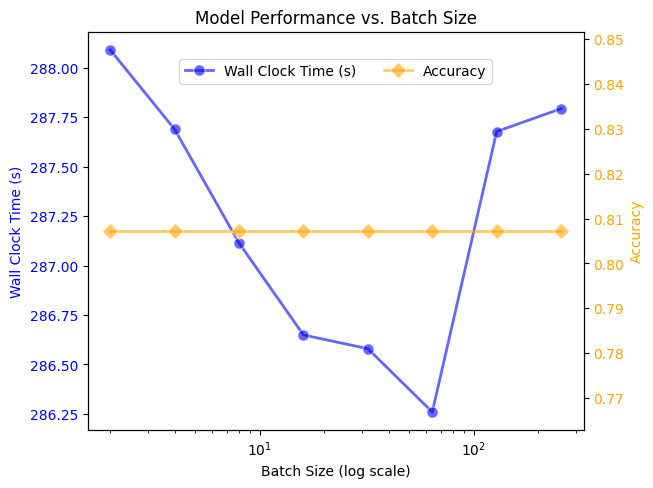

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
# --- Plot 1: Wall Clock Time (in Blue) ---
# Assign a label directly for legend creation
ax = sns.lineplot(
    data=results.T,
    x='batch_size',
    y='wall_clock_time',
    color='blue',                  # Set color to blue
    marker='o',
    markersize=8,
    alpha=0.6,
    lw=2,
    label='Wall Clock Time (s)',   # Legend label for this line
    legend=False
)

# --- Plot 2: Accuracy (in Orange) ---
ax2 = ax.twinx()
sns.lineplot(
    data=results.T,
    x='batch_size',
    y='accuracy',
    color='orange',                # Set color to orange
    marker='D',                    # Different marker for distinction
    markersize=8,
    alpha=0.6,
    lw=2,
    ax=ax2,                        # Plot on the secondary y-axis
    label='Accuracy',               # Legend label for this line
    legend=False
)

# --- Final Touches ---
# Set log scale for the x-axis
ax.set_xscale('log')

# Set axis labels and title
ax.set_xlabel('Batch Size (log scale)')
ax.set_ylabel('Wall Clock Time (s)', color='blue')
ax2.set_ylabel('Accuracy', color='orange')

# Match the tick colors to the lines for clarity
ax.tick_params(axis='y', labelcolor='blue')
ax2.tick_params(axis='y', labelcolor='orange')

# Set the main title
ax.set_title('Model Performance vs. Batch Size')

# Create a single, unified legend
# Get handles and labels from both axes
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
# Combine them and place the legend
ax.legend(h1 + h2, l1 + l2, loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=2)


# plt.tight_layout()
# Adjust layout to make space for the legend below the plot
plt.subplots_adjust(bottom=0.05) 
plt.show()

# testing the role of `num_workers` on Wall Clock Time 

In [10]:
args.num_workers

2

In [11]:
import time

json_filename = args.data_cache / '11_num_workers.json'

if json_filename.exists():
    results = pd.read_json(json_filename)
else:
    all_results = []
    for num_workers in [0, 1, 2, 4, 8, 16]:
        args = fovea.Params(num_workers=num_workers)
        model = load_model(args)
        tic = time.time()
        accuracy = get_validation_accuracy(args, model, val_loader)
        toc = time.time()
        this_result = {         
                        'num_workers': num_workers,
                        'accuracy': accuracy,
                        'wall_clock_time': toc-tic,
                        }
        all_results.append(this_result)
    results = pd.DataFrame(all_results)
    results.to_json(json_filename, orient='index', indent=2)

Evaluating resnet18:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating resnet18:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating resnet18:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating resnet18:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating resnet18:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating resnet18:   0%|          | 0/782 [00:00<?, ?it/s]

In [12]:
results.T

,0,1,2,3,4,5
num_workers,0.000000,1.000000,2.000000,4.000000,8.000000,16.000000
accuracy,0.692340,0.692340,0.692340,0.692340,0.692340,0.692340
wall_clock_time,211.698431,208.002015,207.405638,198.551129,199.025474,200.582669


In [13]:
# %rm {json_filename}

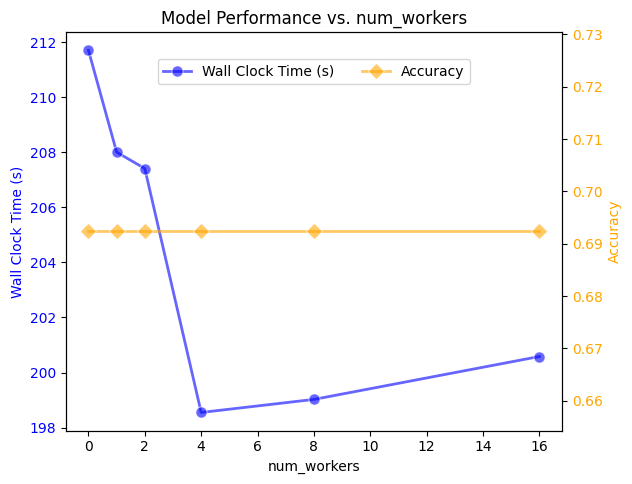

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
# --- Plot 1: Wall Clock Time (in Blue) ---
# Assign a label directly for legend creation
ax = sns.lineplot(
    data=results,
    x='num_workers',
    y='wall_clock_time',
    color='blue',                  # Set color to blue
    marker='o',
    markersize=8,
    alpha=0.6,
    lw=2,
    label='Wall Clock Time (s)',   # Legend label for this line
    legend=False
)

# --- Plot 2: Accuracy (in Orange) ---
ax2 = ax.twinx()
sns.lineplot(
    data=results,
    x='num_workers',
    y='accuracy',
    color='orange',                # Set color to orange
    marker='D',                    # Different marker for distinction
    markersize=8,
    alpha=0.6,
    lw=2,
    ax=ax2,                        # Plot on the secondary y-axis
    label='Accuracy',               # Legend label for this line
    legend=False
)


# Set axis labels and title
ax.set_xlabel('num_workers')
ax.set_ylabel('Wall Clock Time (s)', color='blue')
ax2.set_ylabel('Accuracy', color='orange')

# Match the tick colors to the lines for clarity
ax.tick_params(axis='y', labelcolor='blue')
ax2.tick_params(axis='y', labelcolor='orange')

# Set the main title
ax.set_title('Model Performance vs. num_workers')

# Create a single, unified legend
# Get handles and labels from both axes
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
# Combine them and place the legend
ax.legend(h1 + h2, l1 + l2, loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=2)


# plt.tight_layout()
# Adjust layout to make space for the legend below the plot
plt.subplots_adjust(bottom=0.05) 
plt.show()

# testing different networks

In [ ]:
args = fovea.Params()
from retinoto_py import all_models

json_filename = args.data_cache / '11_model_comparison.json'

if json_filename.exists():
    results = pd.read_json(json_filename)
else:
    all_results = []
    for model_name in all_models:
        tic = time.time()
        args = fovea.Params(model_name=model_name)
        model = load_model(args)
        param_stats = count_parameters(model)
        total_layers = count_layers(model)
        accuracy = get_validation_accuracy(args, model, val_loader)
        toc = time.time()
        this_result = {'model_name': model_name,
                                'accuracy': accuracy,
                                'wall_clock_time': toc-tic,
                                'total_parameters': param_stats['total_parameters'],
                                'trainable_parameters': param_stats['trainable_parameters'],
                                'total_layers': total_layers}
        all_results.append(this_result)
    results = pd.DataFrame(all_results)
    results.to_json(json_filename, orient='index', indent=2)
